In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import mnist_reader, helper
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from scipy.sparse.linalg import eigsh
from numpy.linalg import norm

# for reproducibility, use rs to generate all random quantities
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
rs = RandomState(MT19937(SeedSequence(10012020)))

# Fit a linear error-correcting output coding classification model

Given training data pairs $(x_i, y_i)$, where $x$ are feature vectors and $y$ are integers in $0,1,\ldots,k-1$ learn to predict the class $y$ by associating each class with a codeword--- a $c_j \in \mathbb{R}^\ell$ for $j=0,\ldots,k-1$--- and fitting a model of the form $$c_{y_i} = Wx_i$$ that tries to predict the proper codeword for the class that $x$ is in. Use squared loss $\ell(Wx_i, y_i) = \|c_{y_i} - W x_i \|_2^2$ and use empirical risk minimization to learn $W$:
$$ W_\star = \text{argmin} \frac{1}{n} \sum_{i=1}^n \|c_{y_i} - W x_i\|_2^2 = \frac{1}{n}\|Y - XW\|_2^2, $$
where the $i$th row of the target matrix $Y \in \mathbb{R}^{n \times \ell}$ is the codeword $c_{y_i}$ for the class corresponding to training example $(x_i, y_i)$, and the $i$th row of $X$ is the feature vector $x_i$. (This setup is the transpose of that in the class notes, so the formula for the gradient changes accordingly).

This notebook fits an ECOCC model for the Fashion-MNIST dataset using gradient descent.

In [2]:
X_train, y_train = mnist_reader.load_mnist('data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')

scaler = preprocessing.StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

n_train, d = X_train.shape

In [3]:
# the targets are 0...9

templatedims = 4
templates = rs.randn(10, templatedims)
templates = templates / np.linalg.norm(templates, axis=1, ord=2).reshape(10,1)

def encode_target(y):
    return templates[y]

def recover_target(y):
    diffs = templates - np.repeat(y.reshape(1,templatedims), 10, axis=0)
    dists = np.sum(diffs * diffs, axis=1)
    return np.argmin(dists)

Y_train = np.array([encode_target(y) for y in y_train], dtype=float)
Y_test =  np.array([encode_target(y) for y in y_test], dtype=float)

def f(X, Y, W):
    return 1/2*np.linalg.norm(Y - X @ W)**2

# precomputing these quantities saves a lot of computation time in evaluating the gradient
Hess = X_train.T @ X_train
projY = X_train.T @ Y_train

def grad(W):
    return Hess @ W - projY


In [4]:
# play around with these values to see how they affect convergence and error
evals, _ = eigsh(X_train.T @ X_train)
beta = np.amax(evals)
alpha = 1/beta

T = 5000
Wcur = np.zeros((d, templatedims))

# store objective function values and gradient values after a certain number of steps
storesteps = 100
iterhist = [0]
fhist = [f(X_train, Y_train, Wcur)]
gradhist =[norm(grad(Wcur))]

for t in np.arange(1, T+1):
    Wcur = Wcur - alpha*grad(Wcur)
    if t % storesteps == 0:
        iterhist.append(t)
        fhist.append(f(X_train, Y_train, Wcur))
        gradhist.append(norm(grad(Wcur)))
    

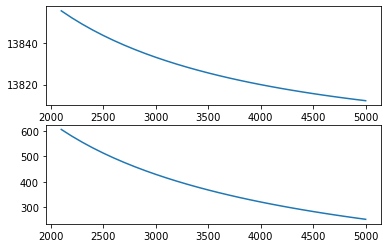

In [11]:
# Plot the objective value and the gradient norms over the last 3000 steps
fig, axes = plt.subplots(2,1)
axes[0].plot(iterhist[-30:], fhist[-30:])
axes[1].plot(iterhist[-30:], gradhist[-30:])

In [20]:
# compute train and test accuracy of the model 
predicted_train_classes = [recover_target(y) for y in X_train @ Wcur]
train_accuracy = accuracy_score(y_train, predicted_train_classes)

predicted_test_classes = [recover_target(y) for y in X_test @ Wcur]
test_accuracy = accuracy_score(y_test, predicted_test_classes)

print("Test/train accuracy: %.2f%%/%.2f%%" % (100*train_accuracy, 100*test_accuracy))

Test/train accuracy: 67.04%/65.66%
